In [5]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils_VBFHH as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import json
import copy
from ROOT import TLorentzVector
import uproot
import seaborn as sn


In [6]:
def load_data_rpd(file_name, branches, process,treedir,selection='',entrystop=None,):

    root_file = uproot.open(file_name)
    df = rpd.read_root(file_name,treedir+process, columns = branches).query(selection)
    print("Entries in ntuple:")
    print(len(df))
    return df

In [7]:
year='2018'


indir = '/work/nchernya/HHbbgg_ETH_devel/root_files/gghh_2jets/'
indir2='/work/nchernya/HHbbgg_ETH_devel/root_files/vbfhh_preselection_wo_ttHkiller/'

file_ggHH_NLO = 'output_hh_nlo_kl_1_kt_1.root'
file_ggHH_LO = 'GluGluToHHTo2B2G_Era2018_RR-17Sep2018_v2.root'

process_ggHH_NLO = 'hh2018_13TeV_125_13TeV_VBFDoubleHTag_0'
process_ggHH_LO = 'hh2018_13TeV_125_13TeV_VBFDoubleHTag_0'

features = 'HHbbggMVA,weight,leadingJet_DeepFlavour,subleadingJet_DeepFlavour,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,noexpand:(leadingPhoton_pt/CMS_hgg_mass),noexpand:(subleadingPhoton_pt/CMS_hgg_mass),noexpand:(leadingJet_pt/Mjj),noexpand:(subleadingJet_pt/Mjj),rho,noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826),PhoJetMinDr,PhoJetOtherDr,noexpand:(VBFleadJet_pt/VBFJet_mjj),VBFleadJet_eta,noexpand:(VBFsubleadJet_pt/VBFJet_mjj),VBFsubleadJet_eta,VBFCentrality_jg,VBFCentrality_jb,VBFDeltaR_jg,VBFDeltaR_jb,VBFProd_eta,VBFJet_mjj,VBFJet_Delta_eta,VBFleadJet_QGL,VBFsubleadJet_QGL,diHiggs_pt,MX'.split(",")
features_for_corr = 'absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,leadingPhoton_pt,subleadingPhoton_pt,CMS_hgg_mass,leadingJet_pt,subleadingJet_pt,Mjj,PhoJetMinDr,PhoJetOtherDr,VBFleadJet_pt,VBFleadJet_eta,VBFsubleadJet_pt,VBFJet_mjj,VBFJet_Delta_eta,diHiggs_pt,MX'.split(",")
features+=features_for_corr

df_ggHH_NLO = load_data_rpd(indir2+file_ggHH_NLO, features+['genweight'], process_ggHH_NLO,'tagsDumper/trees/','(genweight<0.1)') #and(HHbbggMVA>0.7)
features+=['benchmark_reweight_SM']
df_ggHH_LO = load_data_rpd(indir+file_ggHH_LO, features, process_ggHH_LO,'tagsDumper/trees/','(diHiggs_pt>0)') 

Entries in ntuple:
17219
Entries in ntuple:
482573


In [8]:
features = 'weight,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,PhoJetOtherDr,VBFJet_mjj,diHiggs_pt'.split(",")

#features_for_corr = 'absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,leadingPhoton_pt/CMS_hgg_mass,subleadingPhoton_pt/CMS_hgg_mass,leadingJet_pt/Mjj,subleadingJet_pt/Mjj,PhoJetMinDr,PhoJetOtherDr,VBFleadJet_pt/VBFJet_mjj,VBFleadJet_eta,VBFsubleadJet_pt/VBFJet_mjj,VBFJet_mjj,VBFJet_Delta_eta,diHiggs_pt,MX'.split(",")
features_for_corr = 'absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,leadingPhoton_pt,subleadingPhoton_pt,leadingJet_pt,subleadingJet_pt,PhoJetMinDr,PhoJetOtherDr,VBFleadJet_pt,VBFleadJet_eta,VBFsubleadJet_pt,VBFJet_mjj,VBFJet_Delta_eta,diHiggs_pt,MX'.split(",")


In [14]:
labels=[]
outstr = "30_04_2020_ggHH_LO_reweighting_after"
labels.append(outstr)
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [11]:
def reweight(what,df0,df1,bins):
    m0, bins = np.histogram(df0[what],bins=bins,weights=df0["weight"],normed=True)
    m1, _ = np.histogram(df1[what],bins=bins,weights=df1["weight"],normed=True)
    weights = m0.astype(np.float32) / m1.astype(np.float32)
    weights[np.isnan(weights)] = 1.
    bins[-1] = df1[what].max()+1.
    df1["%s_bin"%what] = pd.cut(df1[what],bins,labels=range(0,bins.shape[-1]-1))
    rewei = df1[["%s_bin"%what,"weight"]].apply(lambda x: weights[x[0]]*x[1], axis=1, raw=True)
    df1["weight"] = rewei * df1["weight"].sum() / rewei.sum()
    

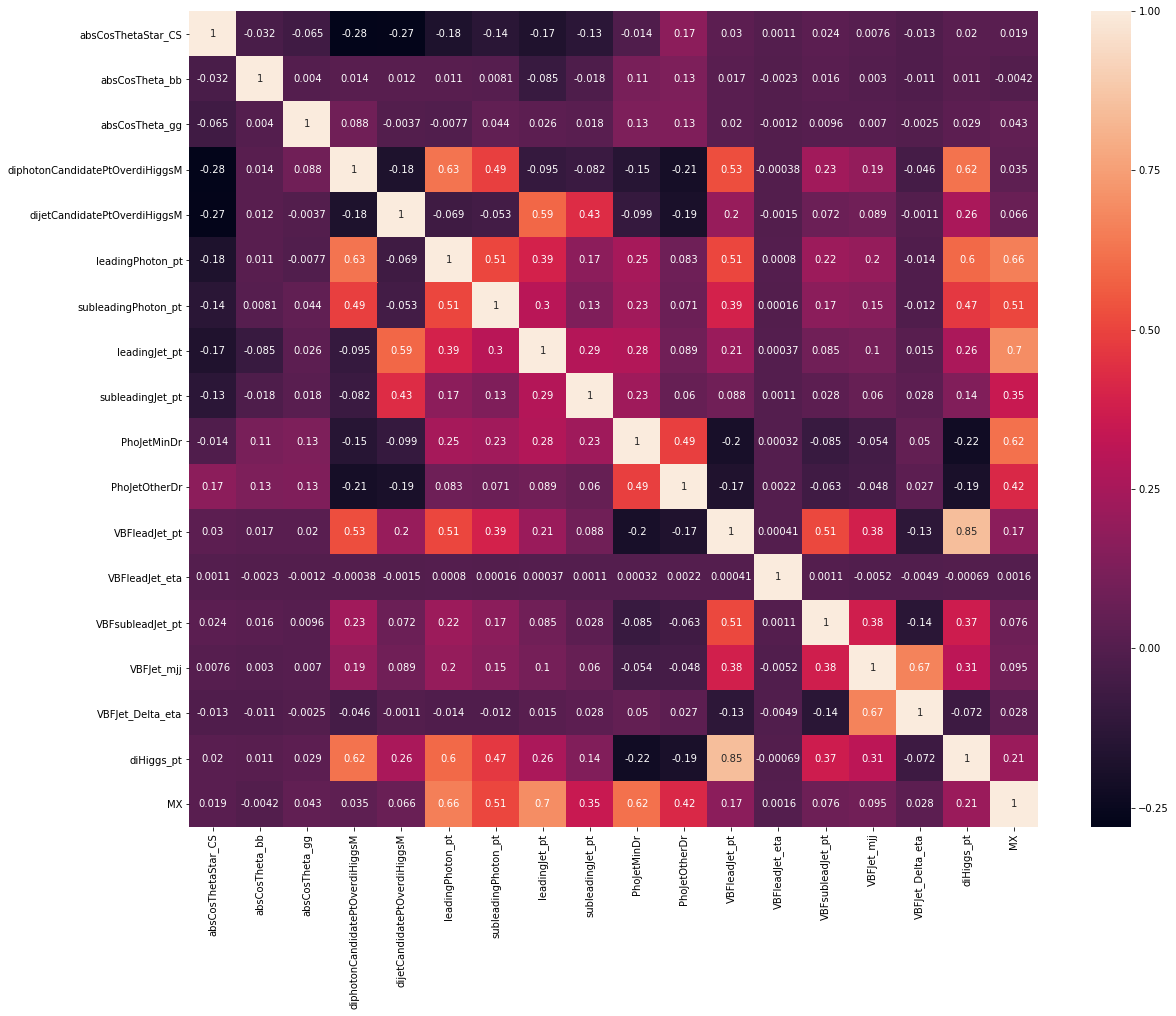

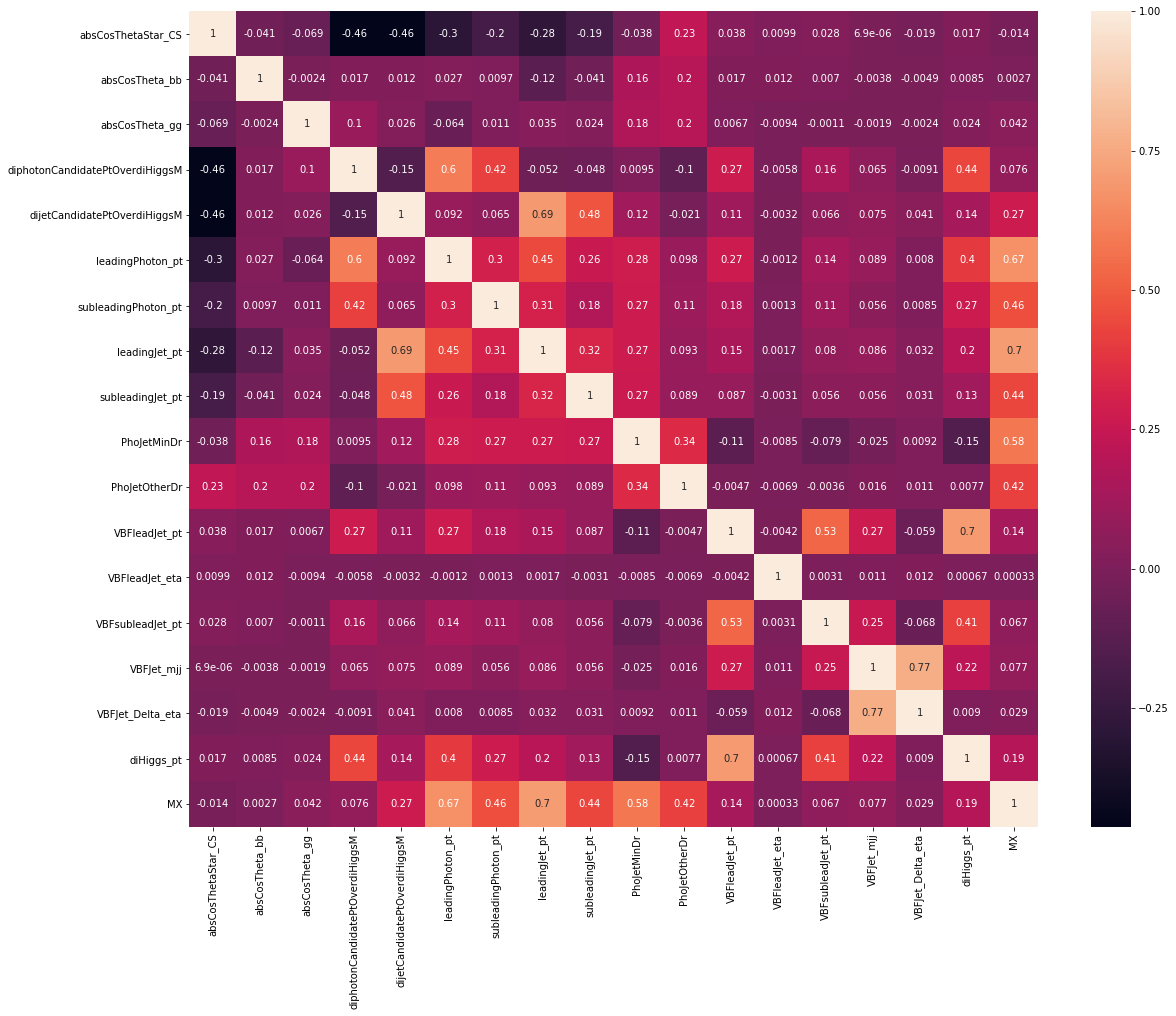

In [12]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df_ggHH_LO[features_for_corr].corr()
sn.heatmap(corrMatrix, annot=True)
plt.savefig(os.path.join(utils.IO.plotFolder, "correlation_matrix_ggHH_LO_before.pdf"))
plt.show()

f = plt.figure(figsize=(19, 15))
corrMatrix = df_ggHH_NLO[features_for_corr].corr()
sn.heatmap(corrMatrix, annot=True)
plt.savefig(os.path.join(utils.IO.plotFolder, "correlation_matrix_ggHH_NLO.pdf"))
plt.show()

In [13]:
reweight('diHiggs_pt',df_ggHH_NLO,df_ggHH_LO,np.linspace(0,600,100))
#reweight('VBFJet_mjj',df_ggHH_NLO,df_ggHH_LO,np.linspace(0,600,100))
reweight('PhoJetMinDr',df_ggHH_NLO,df_ggHH_LO,np.linspace(0,3,100))

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports

HHbbggMVA


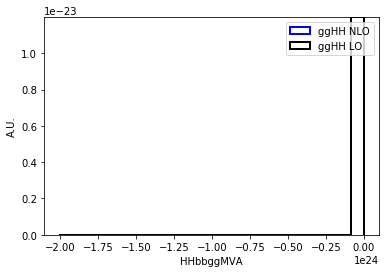

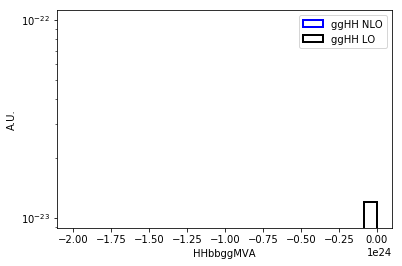

leadingJet_DeepFlavour


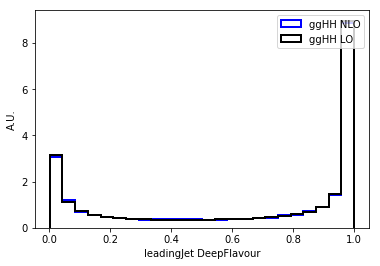

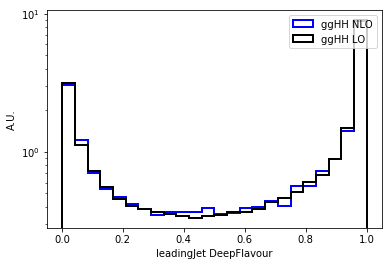

subleadingJet_DeepFlavour


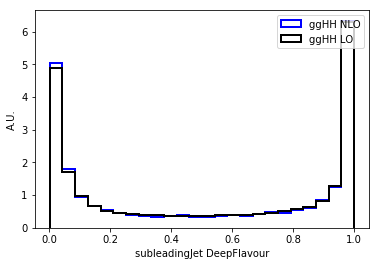

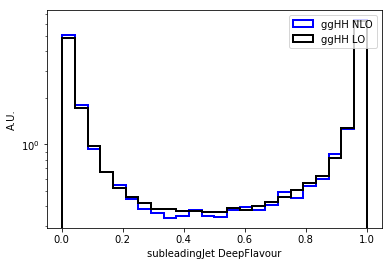

absCosThetaStar_CS


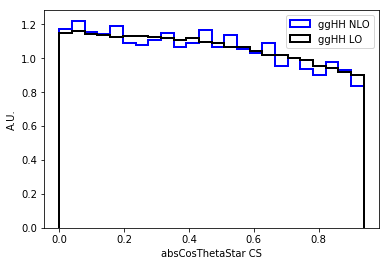

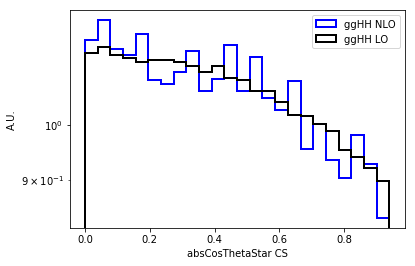

absCosTheta_bb


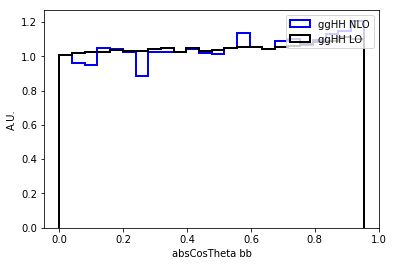

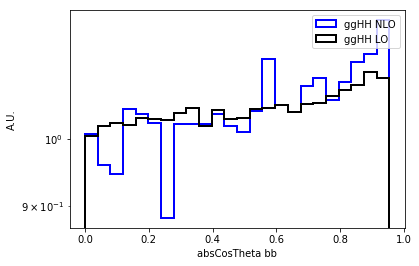

absCosTheta_gg


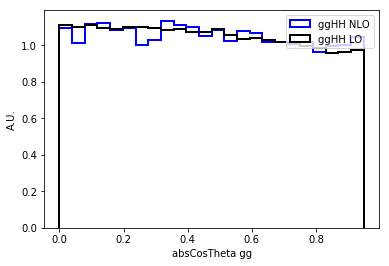

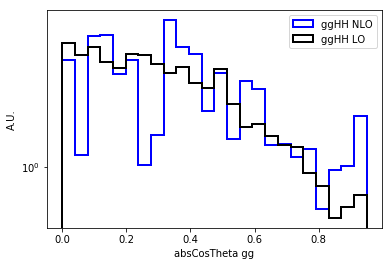

diphotonCandidatePtOverdiHiggsM


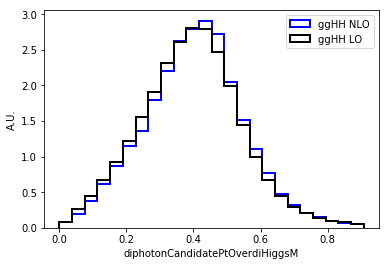

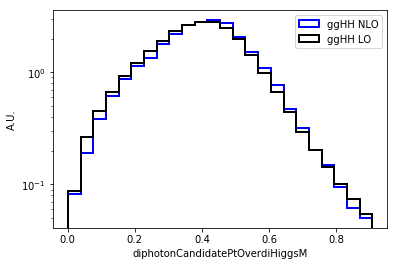

dijetCandidatePtOverdiHiggsM


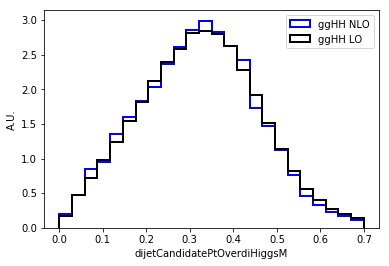

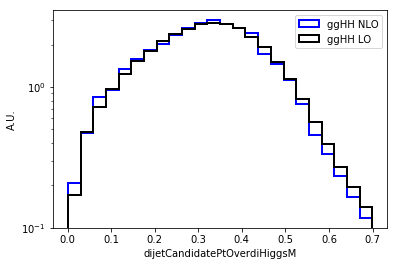

customLeadingPhotonIDMVA


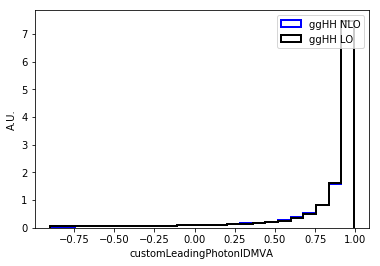

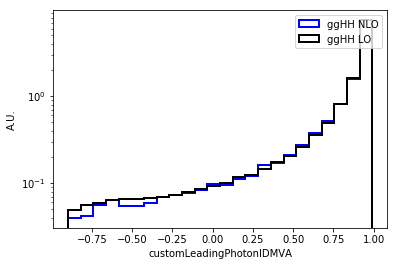

customSubLeadingPhotonIDMVA


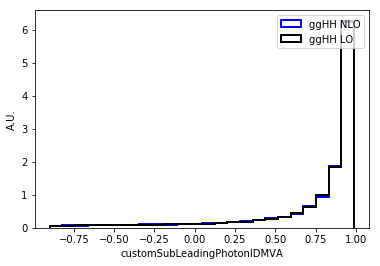

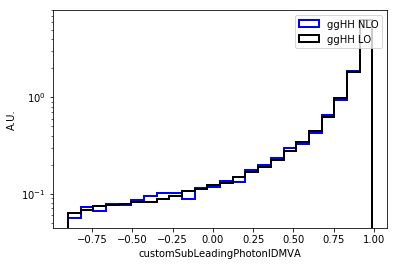

leadingPhotonSigOverE


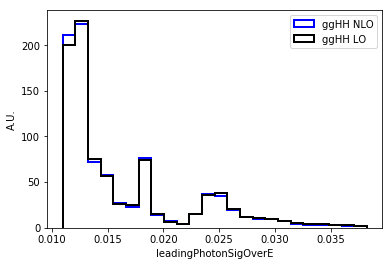

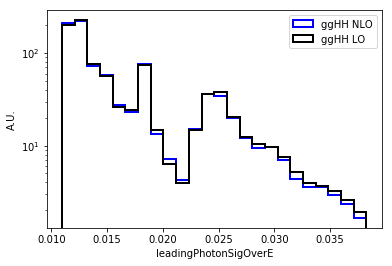

subleadingPhotonSigOverE


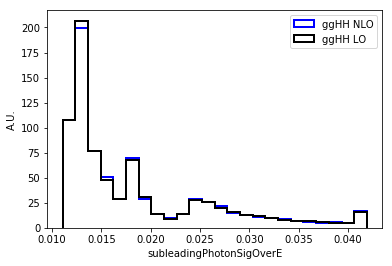

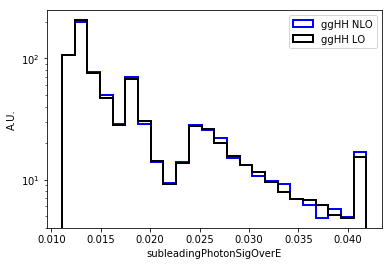

sigmaMOverM


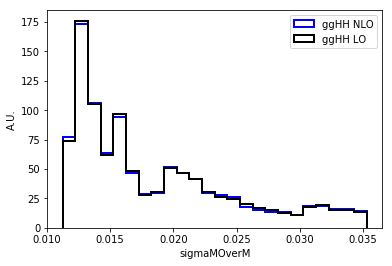

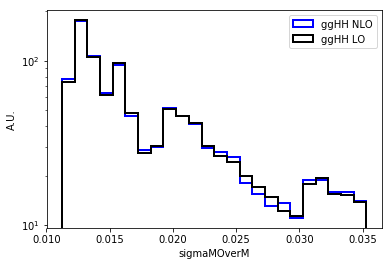

noexpand:(leadingPhoton_pt/CMS_hgg_mass)


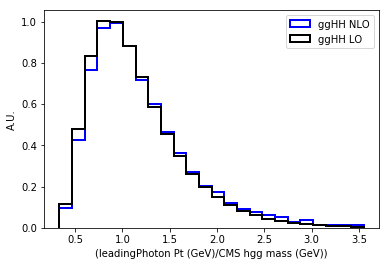

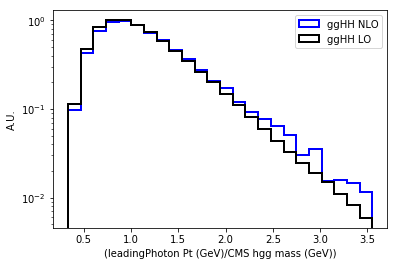

noexpand:(subleadingPhoton_pt/CMS_hgg_mass)


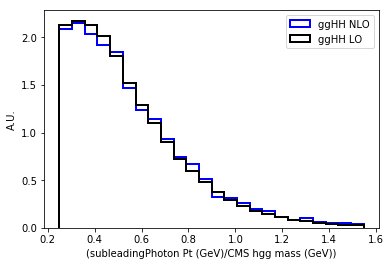

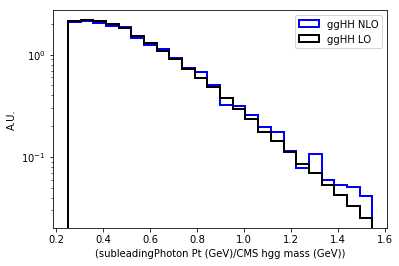

noexpand:(leadingJet_pt/Mjj)


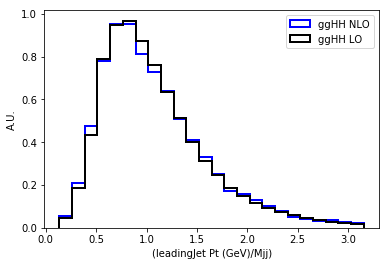

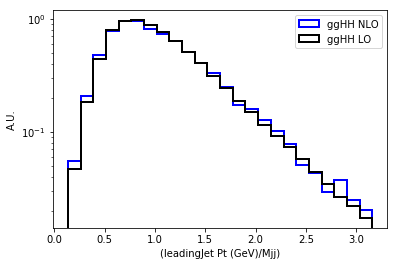

noexpand:(subleadingJet_pt/Mjj)


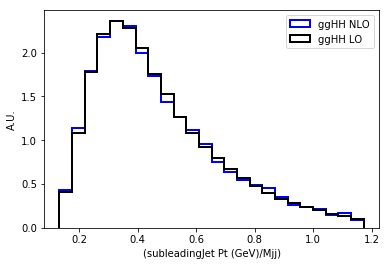

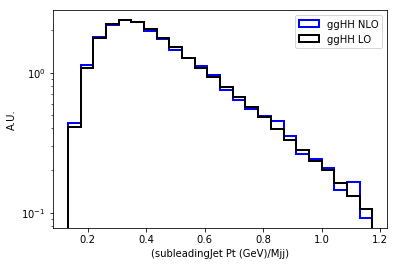

rho


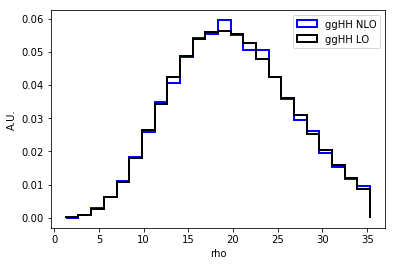

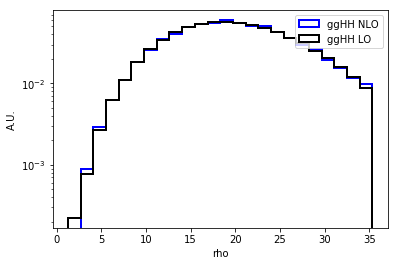

noexpand:(leadingJet_bRegNNResolution*1.4826)


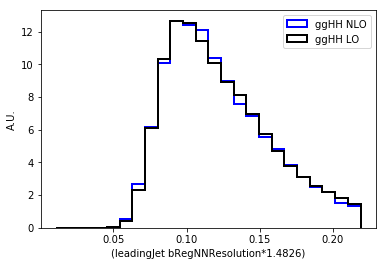

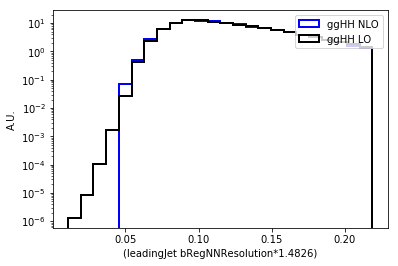

noexpand:(subleadingJet_bRegNNResolution*1.4826)


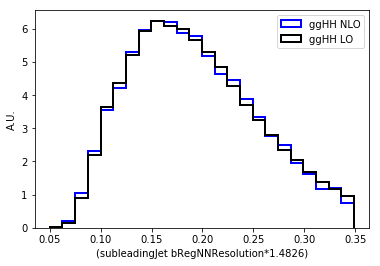

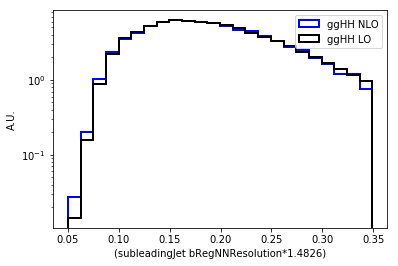

noexpand:(sigmaMJets*1.4826)


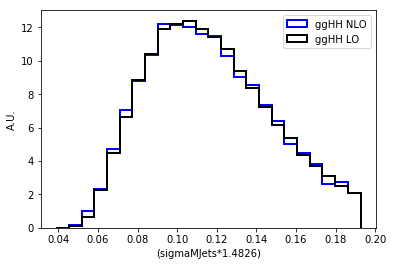

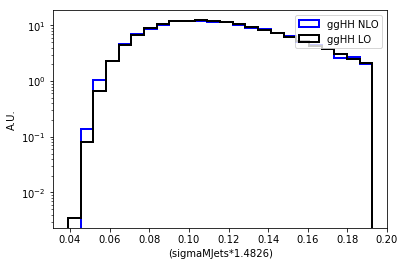

PhoJetMinDr


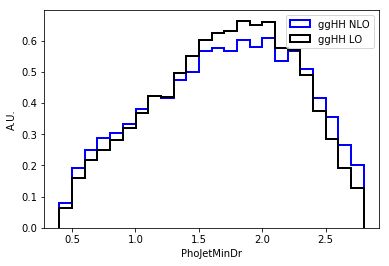

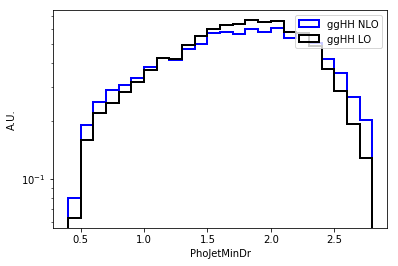

PhoJetOtherDr


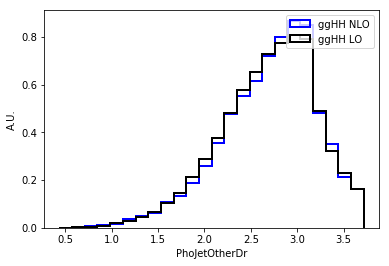

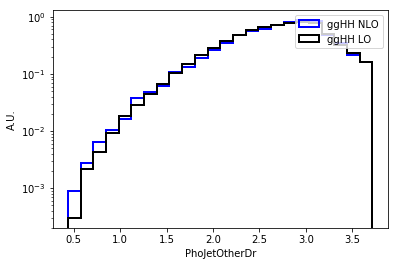

noexpand:(VBFleadJet_pt/VBFJet_mjj)


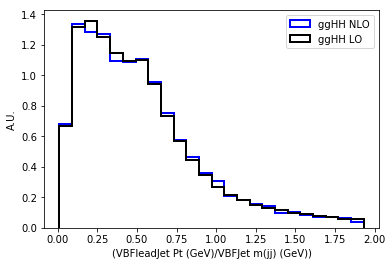

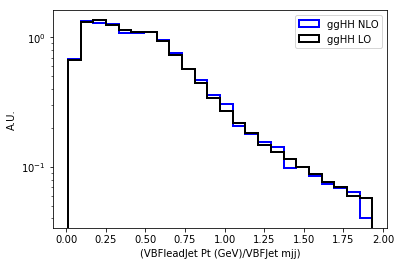

VBFleadJet_eta


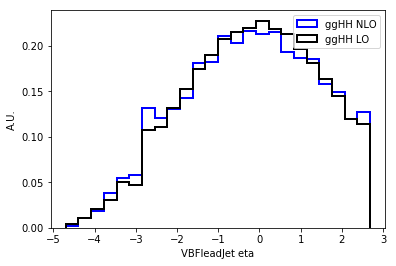

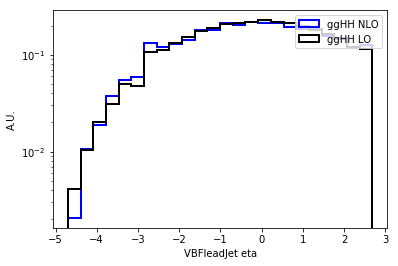

noexpand:(VBFsubleadJet_pt/VBFJet_mjj)


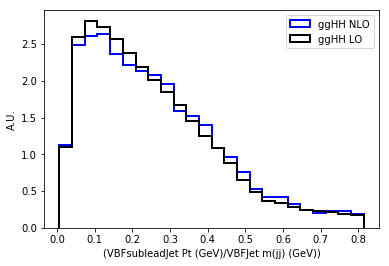

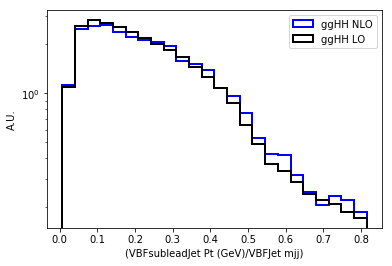

VBFsubleadJet_eta


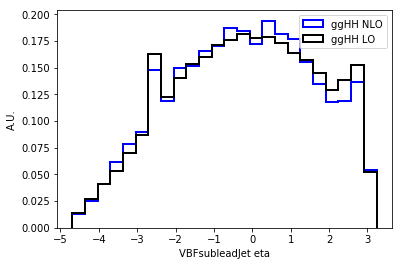

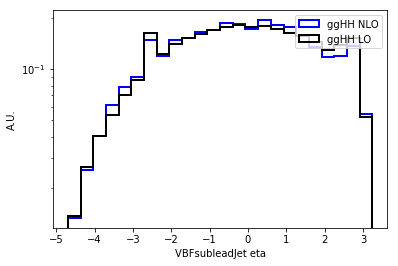

VBFCentrality_jg


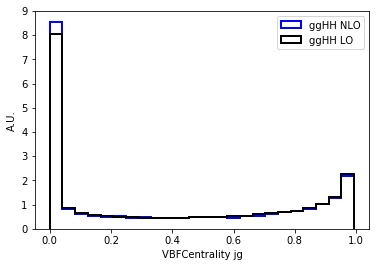

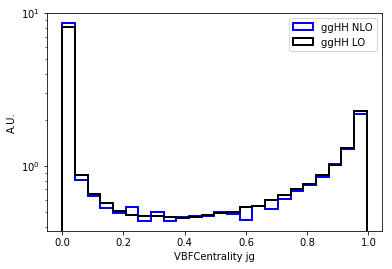

VBFCentrality_jb


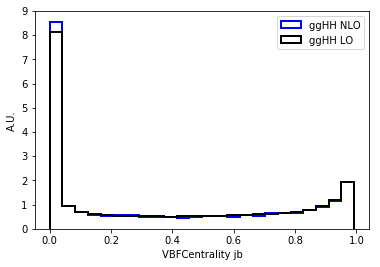

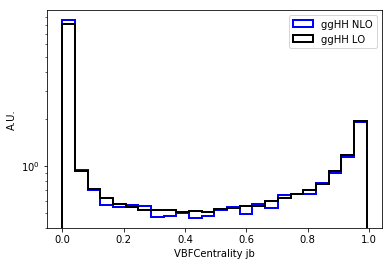

VBFDeltaR_jg


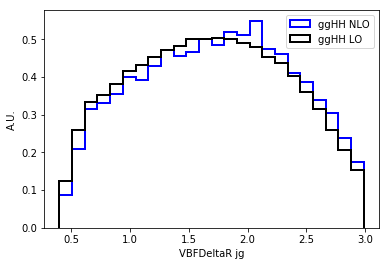

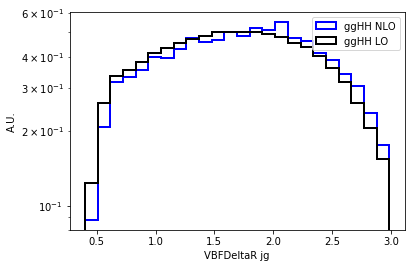

VBFDeltaR_jb


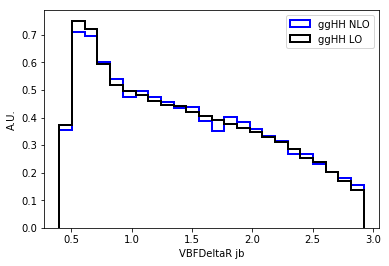

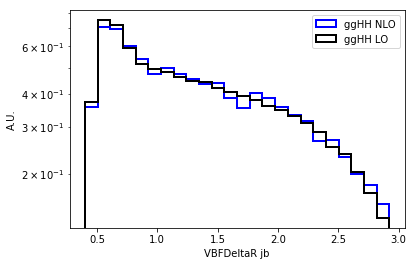

VBFProd_eta


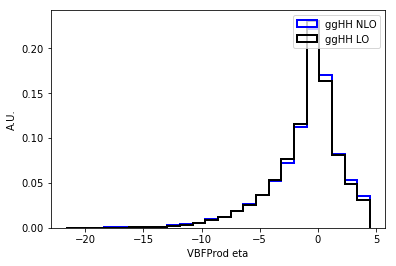

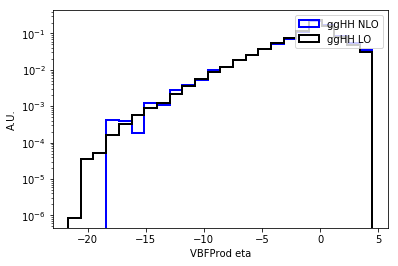

VBFJet_mjj


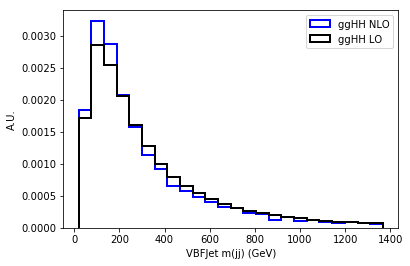

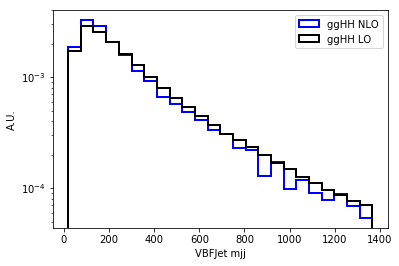

VBFJet_Delta_eta


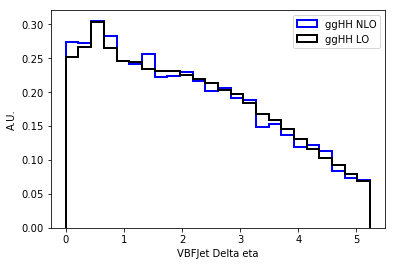

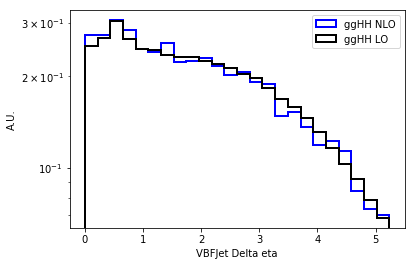

VBFleadJet_QGL


/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/numpy/lib/histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


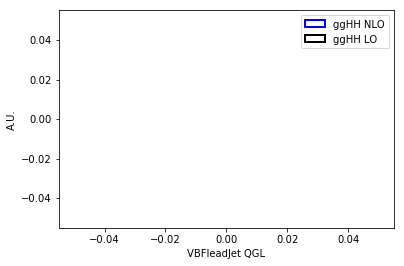

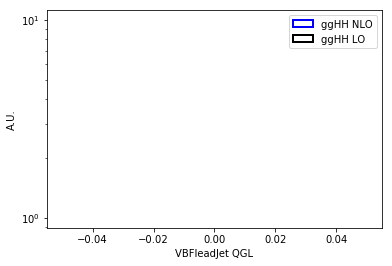

VBFsubleadJet_QGL


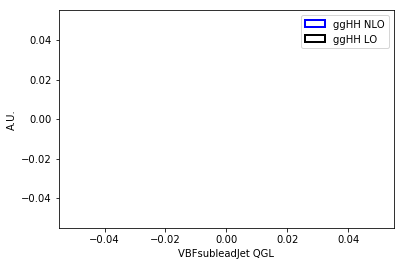

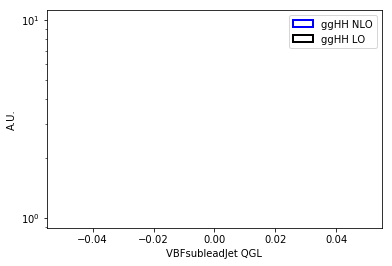

diHiggs_pt


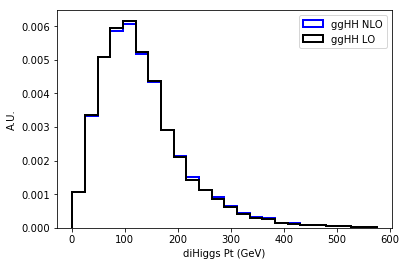

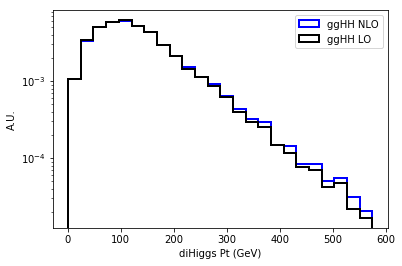

MX


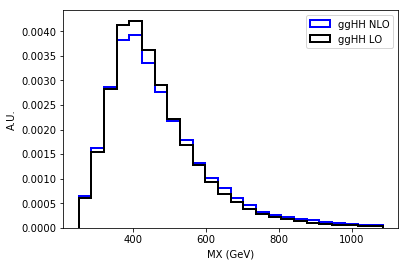

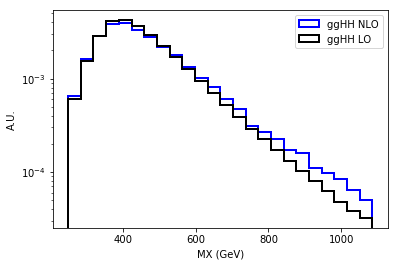

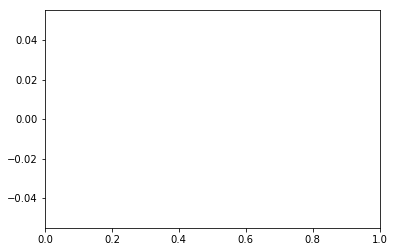

In [16]:
features = 'HHbbggMVA,weight,leadingJet_DeepFlavour,subleadingJet_DeepFlavour,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,noexpand:(leadingPhoton_pt/CMS_hgg_mass),noexpand:(subleadingPhoton_pt/CMS_hgg_mass),noexpand:(leadingJet_pt/Mjj),noexpand:(subleadingJet_pt/Mjj),rho,noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826),PhoJetMinDr,PhoJetOtherDr,noexpand:(VBFleadJet_pt/VBFJet_mjj),VBFleadJet_eta,noexpand:(VBFsubleadJet_pt/VBFJet_mjj),VBFsubleadJet_eta,VBFCentrality_jg,VBFCentrality_jb,VBFDeltaR_jg,VBFDeltaR_jb,VBFProd_eta,VBFJet_mjj,VBFJet_Delta_eta,VBFleadJet_QGL,VBFsubleadJet_QGL,diHiggs_pt,MX'.split(",")

#plotting routine
numbins=25
for feat in features:
    if 'weight' in feat: 
        continue
    if 'MVAOutputTransformed' in feat: 
        continue
    print feat 
    feat=feat.replace('noexpand:','')
    #set the same range
    nbins = np.linspace(min(df_ggHH_LO[feat]), np.quantile(df_ggHH_LO[feat],0.95) , numbins)
     
    val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_ggHH_NLO[feat],label='ggHH NLO',histtype='step',bins=nbins,color='blue',density='True',weights=df_ggHH_NLO['weight'],linewidth=2.0)
    val_of_bins_x2, edges_of_bins_x2, patches_x2  = plt.hist(df_ggHH_LO[feat],label='ggHH LO',histtype='step',bins=nbins,color='black',density='True',weights=df_ggHH_LO['weight']*df_ggHH_LO['benchmark_reweight_SM'],linewidth=2.0)
    plt.legend(loc="upper right")
    plt.ylabel('A.U.')
    plt.xlabel(feat.replace('_',' ').replace('pt','Pt (GeV)').replace('MX','MX (GeV)').replace('genMhh','gen M(HH) (GeV)').replace('mass','mass (GeV)').replace('mjj','m(jj) (GeV)'))
    plt.savefig(os.path.join(utils.IO.plotFolder, str(feat).replace('/','_').replace('(','').replace(')','')+".png"))
    plt.show()
    
    plt.yscale('log')
    val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_ggHH_NLO[feat],label='ggHH NLO',histtype='step',bins=nbins,color='blue',density='True',weights=df_ggHH_NLO['weight'],linewidth=2.0)
    val_of_bins_x2, edges_of_bins_x2, patches_x2  = plt.hist(df_ggHH_LO[feat],label='ggHH LO',histtype='step',bins=nbins,color='black',density='True',weights=df_ggHH_LO['weight']*df_ggHH_LO['benchmark_reweight_SM'],linewidth=2.0)
    plt.ylabel('A.U.')
    plt.xlabel(feat.replace('_',' ').replace('pt','Pt (GeV)').replace('MX','MX (GeV)').replace('genMhh','gen M(HH) (GeV)').replace('mass','mass (GeV)'))
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(utils.IO.plotFolder, str(feat).replace('/','_').replace('(','').replace(')','')+"_log.png"))


    plt.show()
    plt.yscale('linear')


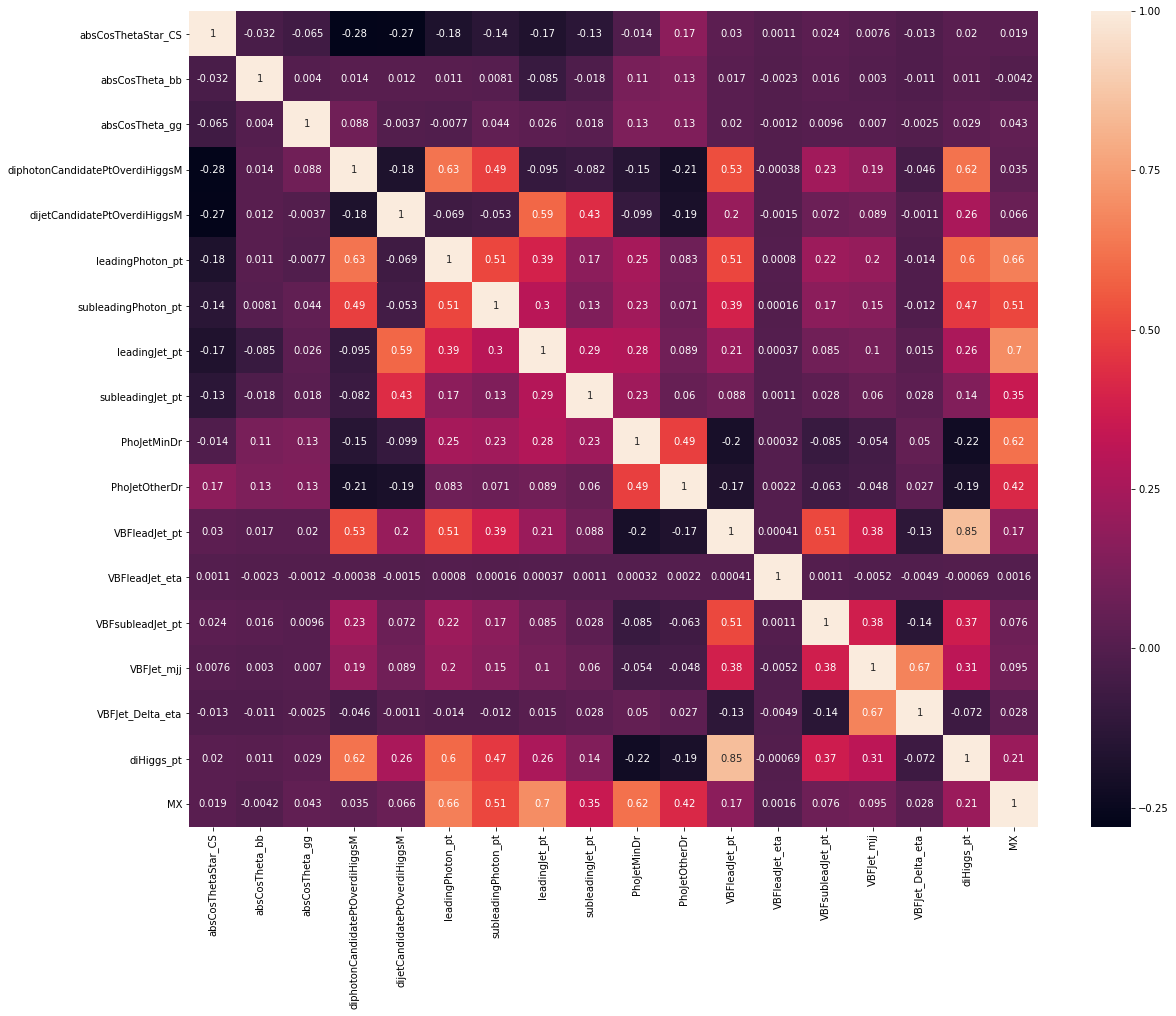

In [17]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df_ggHH_LO[features_for_corr].corr()
sn.heatmap(corrMatrix, annot=True)
plt.savefig(os.path.join(utils.IO.plotFolder, "correlation_matrix_ggHH_LO_after.pdf"))
plt.show()